# Advanced Lane Finding 

In this project, I have made my best attempts to address the goals that are given below
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

## Let's look at the sample images given to us

In [2]:
def load_image(img):
    return mpimg.imread(img)

In [3]:
def plot_chess_image(image):
#     img = mpimg.imread('camera_cal/calibration'+str(num)+'.jpg')
    img = load_image(image)
    image_shape = img.shape
    print('Shape of the image is: '+str(image_shape))
    plt.imshow(img)

Shape of the image is: (720, 1280, 3)


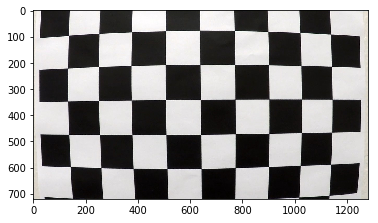

In [4]:
plot_chess_image('camera_cal/calibration1.jpg')

Shape of the image is: (720, 1280, 3)


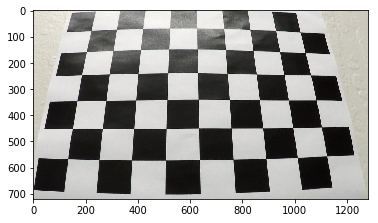

In [5]:
plot_chess_image('camera_cal/calibration3.jpg')

Shape of the image is: (720, 1280, 3)


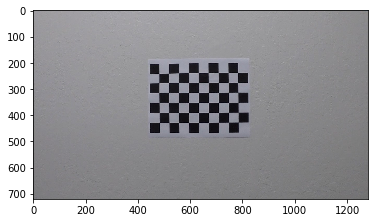

In [6]:
plot_chess_image('camera_cal/calibration6.jpg')

As we understand that the number of points of interest, are "corners" they're only points where two black and two white squares intersect, in other words, only count inside corners, not outside corners i.e. the inside points, not the outside points, we can observe that there are 9 corners in a row and 6 corners in a column.

So we define, 
number of points in x `nx` = 9<br>
number of points in x `ny` = 6

In [7]:
nx = 9
ny = 6

Let's understand how to draw the corners of the chessboard given in the images

In [8]:
def draw_corners(recd_img):
    img = cv2.imread(recd_img) # recd_img is the filename of the file of interest
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        print('Corners found, find the image below:')
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
    else:
        print('Corners Not Found')

Corners found, find the image below:


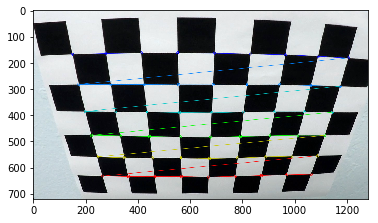

In [9]:
draw_corners('camera_cal/calibration2.jpg')

Let's try to compute the camera calibration matrix<br>
Also, let's find out the distortion coefficients.

In [10]:
objpoints = []
imgpoints = []

# over here an image in x,y,z dimensions is getting generated
objp = np.zeros((nx*ny,3), np.float32) # here we leave the z coordinate as it remains 0 by default and we don't need z axis
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # here we get the coordinates of the grid size and we tarnspose it

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # feeding gray image to find corners
    if ret:
        objpoints.append(objp) # object points are detected and appended here, we will use them to calibrate camera
        imgpoints.append(corners) # corners are detected and appended here
        

In [11]:
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [12]:
def image_dist_undist(num):
    '''This function is used to plot distorted and undistorted image after calibration'''
    img = mpimg.imread('camera_cal/calibration'+str(num)+'.jpg')
    
    undistorted = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix) # this function undistorts the img
    # undistorted is the undistorted or destination image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

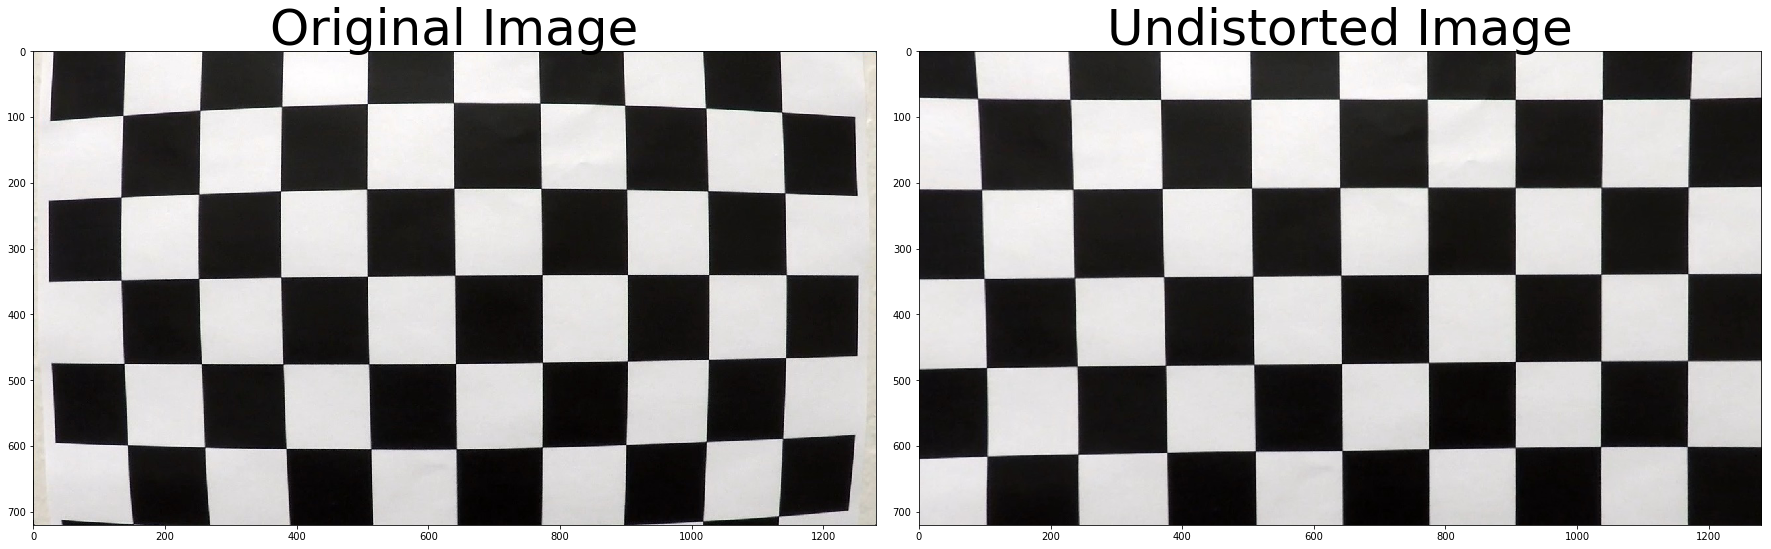

In [13]:
image_dist_undist(1)

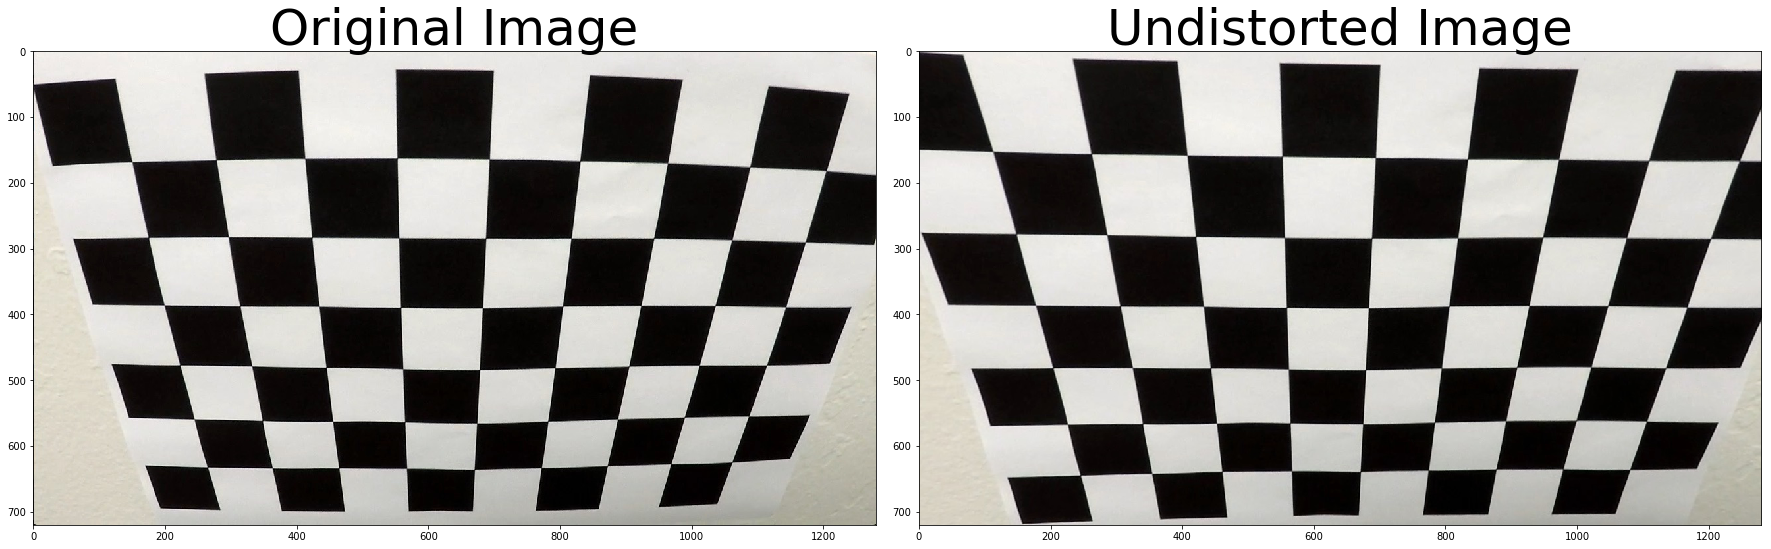

In [14]:
image_dist_undist(2)

if we want to detect the corners and plot them as well, we can use the function `cv2.drawChessboardCorners()`

How to achieve the linear transformation of any shape.
First we define 4 points that identify a rectangle on the plane of the image which needs a transform and then apply transformation from one perspective to another.

For applying the perspective transform we would need,
1. Source points
2. Destination points

using the function `cv2.getPerspectiveTransform(src, dst)` we can get started for the transformed image, we will call it `M`. This would return us the mapping perspective matrix which we would use to get the transformed image.

we can use `%matplotlib qt` to open an image viewer from where we can get the coordinates

`cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_LINEAR)` is the function which would actually return us the warped image



# Gradient Threshold
Realistically we know well that in Lane Detection we are looking for lines which are tending to be close to vertical (i.e. which can be the lane lines) so using Canny Algorithm wouldn't be of much use.

So we are going to detect the steep edges which are going to be more likely to be lanes in the first place.


# Sobel Operator

To understand how these operators take the derivative, you can think of overlaying either one on a 3 x 3 region of an image. If the image is flat across that region (i.e., there is little change in values across the given region), then the result (summing the element-wise product of the operator and corresponding image pixels) will be zero.

If, instead, for example, you apply the Sobel(x) operator to a region of the image where values are rising from left to right, then the result will be positive, implying a positive derivative.

we pass only a single channel image to the sobel operator so we first convert it to the Grayscale image
<br>
While converting we need to take care of the following points,
- Make sure to use the correct grayscale conversion depending on how we've read in your images. 
- We will Use `cv2.COLOR_RGB2GRAY` if we've read in an image using `mpimg.imread()`. We will Use `cv2.COLOR_BGR2GRAY` if we've read in an image using `cv2.imread().`

### Important points to understand:
<br>

Calculate the derivative in the xx direction (the 1, 0 at the end denotes xx direction):
`sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)`
<br>
Calculate the derivative in the yy direction (the 0, 1 at the end denotes yy direction):
`sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)`
<br>
Calculate the absolute value of the xx derivative:
`abs_sobelx = np.absolute(sobelx)`
<br>
Convert the absolute value image to 8-bit:
`scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))`



# Create a binary threshold to select pixels based on gradient strength:
`thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')`

In [15]:
image = plt.imread('test_images/test2.jpg')

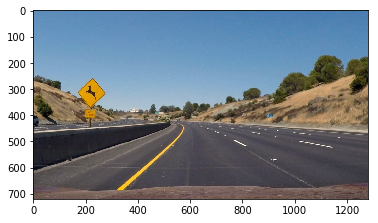

In [16]:
plt.imshow(image)

In [17]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(20,20)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

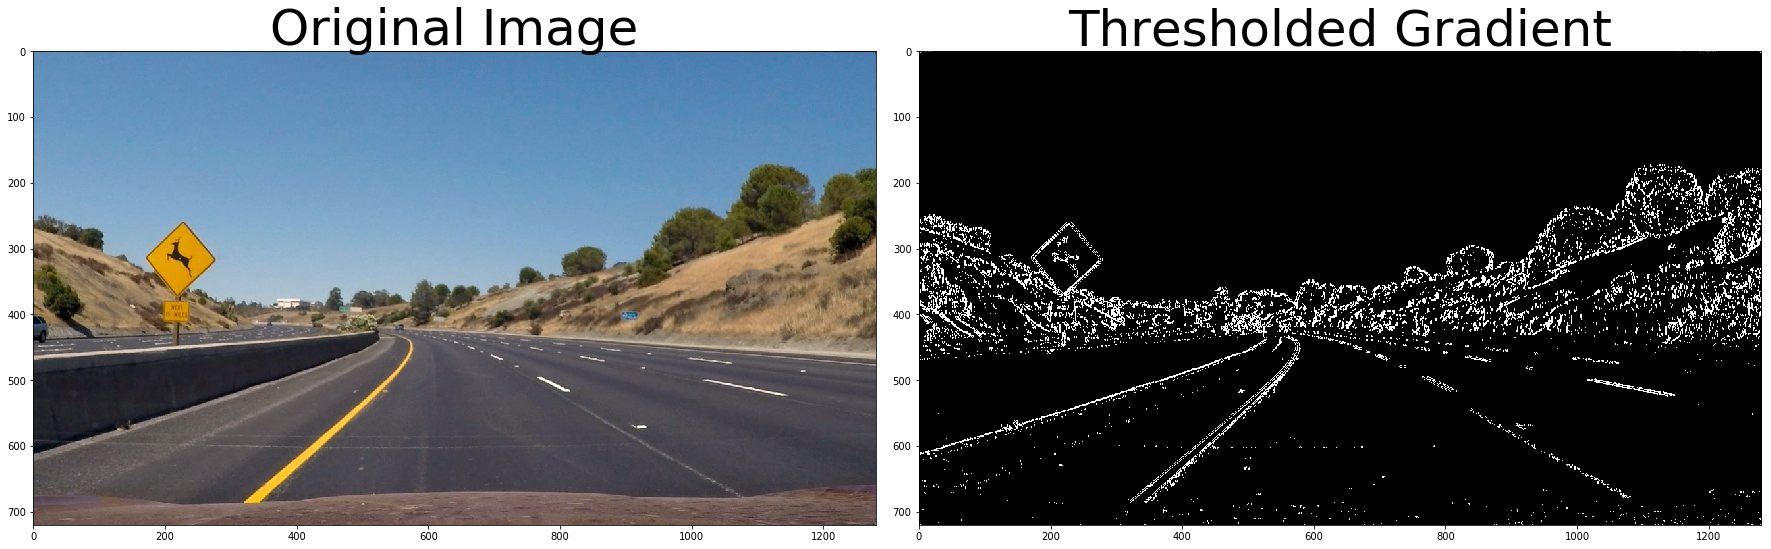

In [18]:
# Run the function abs_sobel_thresh
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20,80))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# When our goal is to apply a threshold to the overall magnitude of the gradient, in both x and y.
we take the sobel values for both x and y direction and take take the square root sum of the sum of their individual squares.

$$gradmag = sqrt{x^2 + y^2}$$

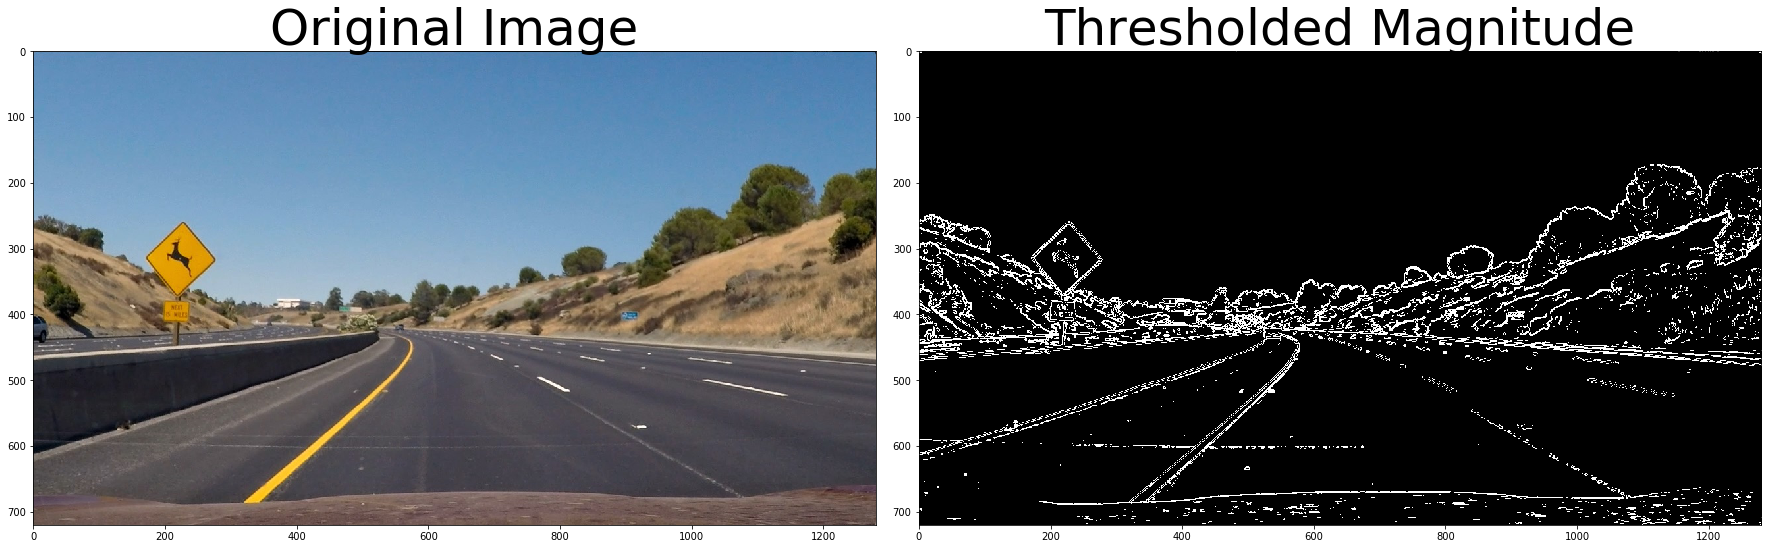

In [19]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad_mag = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Direction of the Gradient
Gradient magnitude is at the heart of Canny edge detection, and is why Canny works well for picking up all edges.<br>
In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient.

The direction of the gradient is simply the inverse tangent (arctangent) of the yy gradient divided by the xx gradient
$$arctan(sobel_x/sobel_y)$$

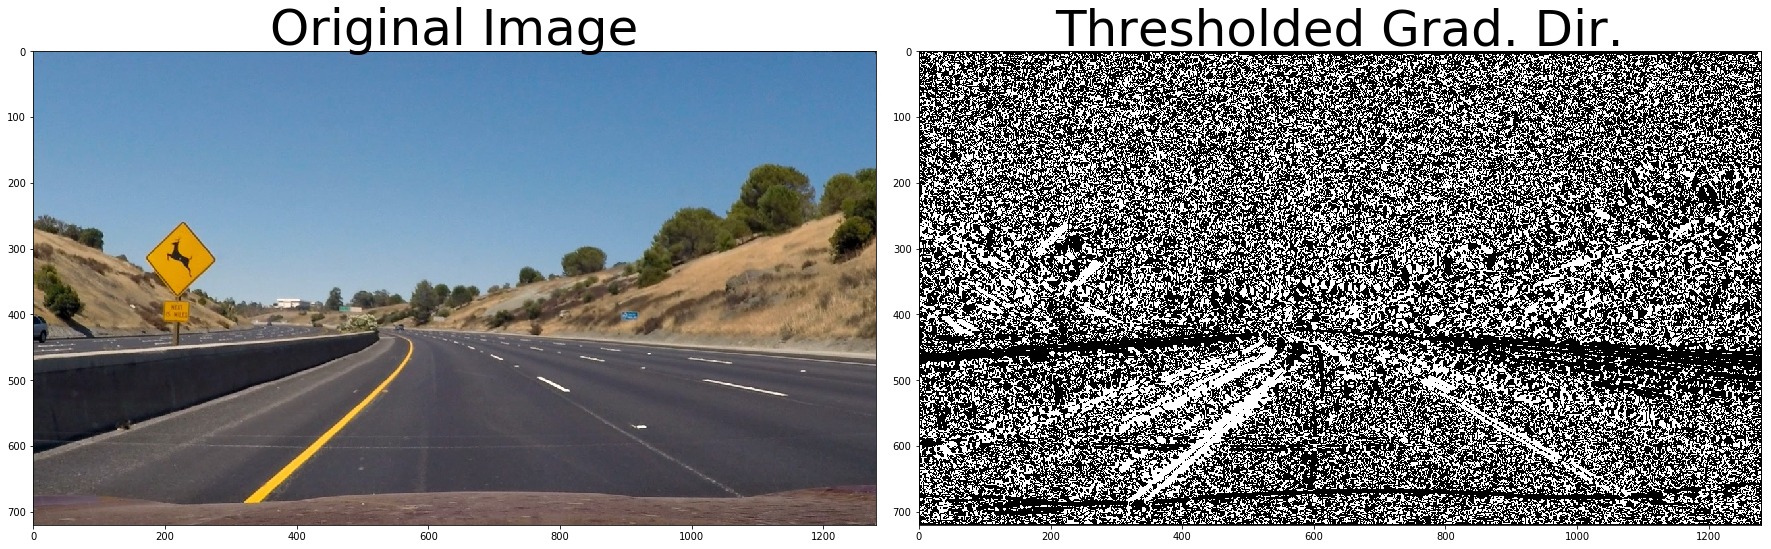

In [20]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [21]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
def combined_transform(image):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20,100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

Tried different combinations here and got explore wonderful variations.
Now I am trying to combine all the conditions here as a selection for pixels where both the `x` and `y` gradients meet the threshold criteria, or the gradient magnitude and direction are both within their threshold values.

In [22]:
combined_img = combined_transform(image)

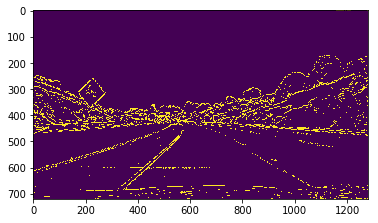

In [23]:
plt.imshow(combined_img)

# Different Color Spaces.

A color space is a specific organization of colors; color spaces provide a way to categorize colors and represent them in digital images.

1. RGB color Space
        RGB is red-green-blue color space. You can think of this as a 3D space, in this case a cube, where any color can be represented by a 3D coordinate of R, G, and B values. For example, white has the coordinate (255, 255, 255), which has the maximum value for red, green, and blue.
<img src="files/RGB_color_space.png">
Note: If you read in an image using `matplotlib.image.imread()` you will get an RGB image, but if you read it in using OpenCV `cv2.imread()` this will give you a BGR image.

2. HLS and HSV Color Space
<img src="files/HLS HSV color space.png">

There are many other ways to represent the colors in an image besides just composed of red, green, and blue values.

There is also HSV color space (hue, saturation, and value), and HLS space (hue, lightness, and saturation). These are some of the most commonly used color spaces in image analysis.

To get some intuition about these color spaces, you can generally think of Hue as the value that represents color independent of any change in brightness. So if you imagine a basic red paint color, then add some white to it or some black to make that color lighter or darker -- the underlying color remains the same and the hue for all of these colors will be the same.

On the other hand, Lightness and Value represent different ways to measure the relative lightness or darkness of a color. For example, a dark red will have a similar hue but much lower value for lightness than a light red. Saturation also plays a part in this; saturation is a measurement of colorfulness. So, as colors get lighter and closer to white, they have a lower saturation value, whereas colors that are the most intense, like a bright primary color (imagine a bright red, blue, or yellow), have a high saturation value. You can get a better idea of these values by looking at the 3D color spaces pictured below.

Most of these different color spaces were either inspired by the human vision system, and/or developed for efficient use in television screen displays and computer graphics. You can read more about the history and the derivation of HLS and HSV color spaces <a href="https://en.wikipedia.org/wiki/HSL_and_HSV">here</a>.

In [24]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(150, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

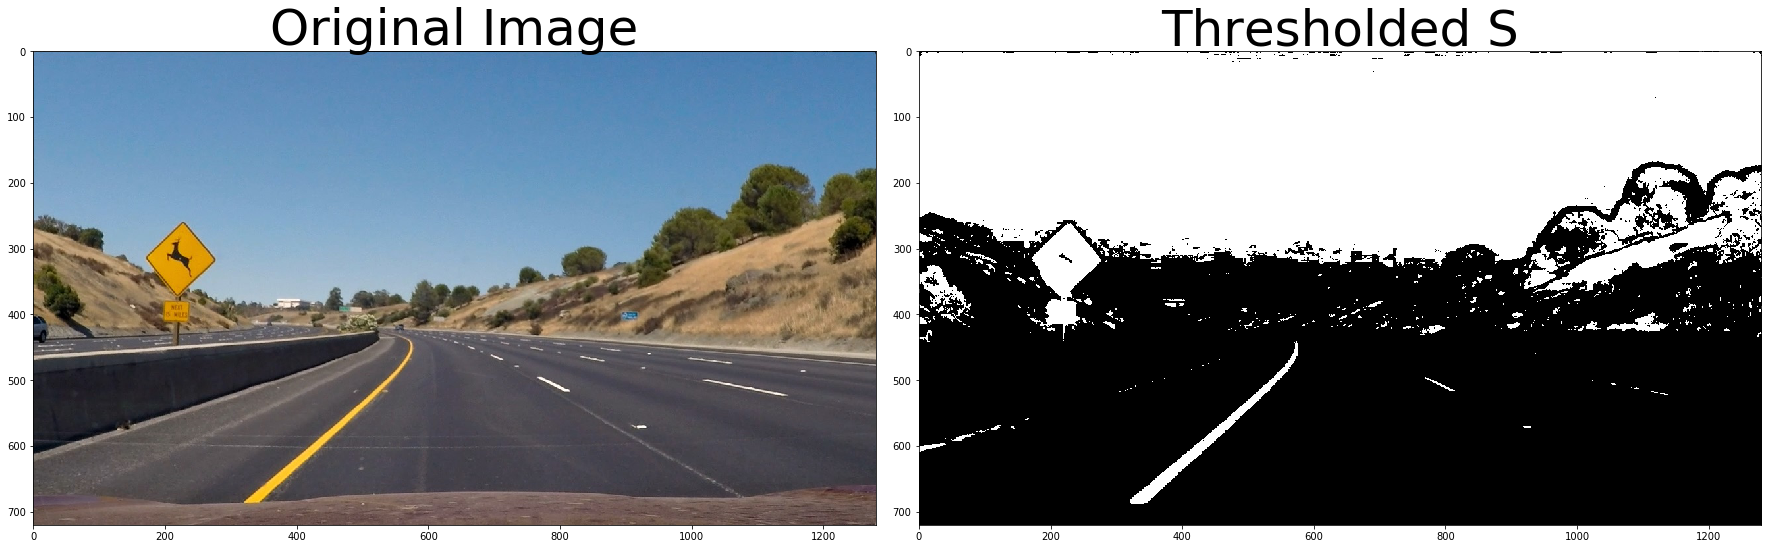

In [25]:
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

At this point, it's okay to detect edges around trees or cars because these lines can be mostly filtered out by applying a mask to the image and essentially cropping out the area outside of the lane lines. It's most important that you reliably detect different colors of lane lines under varying degrees of daylight and shadow.

You can clearly see which parts of the lane lines were detected by the gradient threshold and which parts were detected by the color threshold by stacking the channels and seeing the individual components. You can create a binary combination of these two images to map out where either the color or gradient thresholds were met.

Here's what that looks like in code:

# Perspective Transform

Here we are going to perform the perspective transform. Using this image we would perform our polynomimal fit for the lane lines.

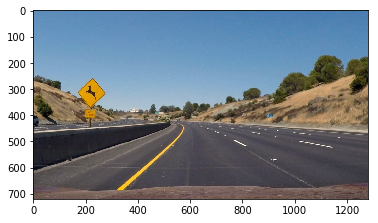

In [26]:
%matplotlib qt
plt.imshow(image)

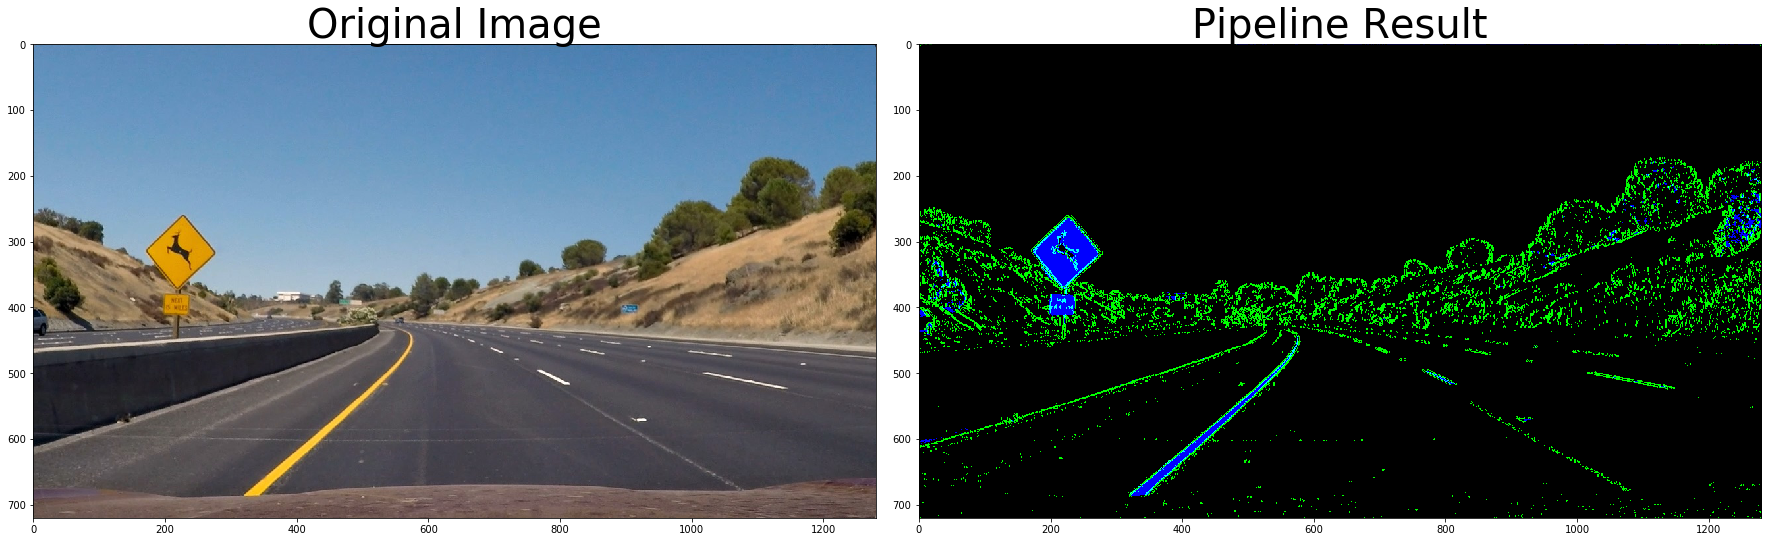

In [27]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding the lane curvature,

If our original image is
<img src="files/original_image.png">

1. Detect lane lines using masking and thresholding techniques
<img src="files/thresholded image.png">

2. Then we will perform the perspective transform to get a birds eye view of the lane.
<img src="files/perspective transform.png">

The above steps let's us fit a polynomial to the lane lines. This was not possible in the previous project. Now if we encounter any curved lines also, we would be able to detect them.
3. Then we can extract the curvature of the lines from this polynomial.
<img src="files/finding curvature.png">

# A little about perspectives

The phenomenon where the Objects appear smaller the farther it is away from the viewpoint and parallel lines seem to converse at a point.

in an image, the points farther from the camera would be appearing smaller in size and the objects closer to it would be larger in appearance, so we can understand from the computer vision point of view that, since our coordinates start from the top left corner, the objects which are closer would have larger values of z value the smaller it would appear in a 2D image.

So perspective transform makes the image a proper 2D image which has it's z coordinates 0 or even. For example,
<img src="files/perspective_transform1.png">

With this we can get the bird's eye view of the image. Which makes it easier for us to perform the curvature finding of the lines.

Till now we were doing the undistortion of the chess board which essentially gave us the output
<img src="files/perspective_transform3.png">

but now we intend to solve the problem of actual image for example,
<img src=files/perspective_transform2.png>

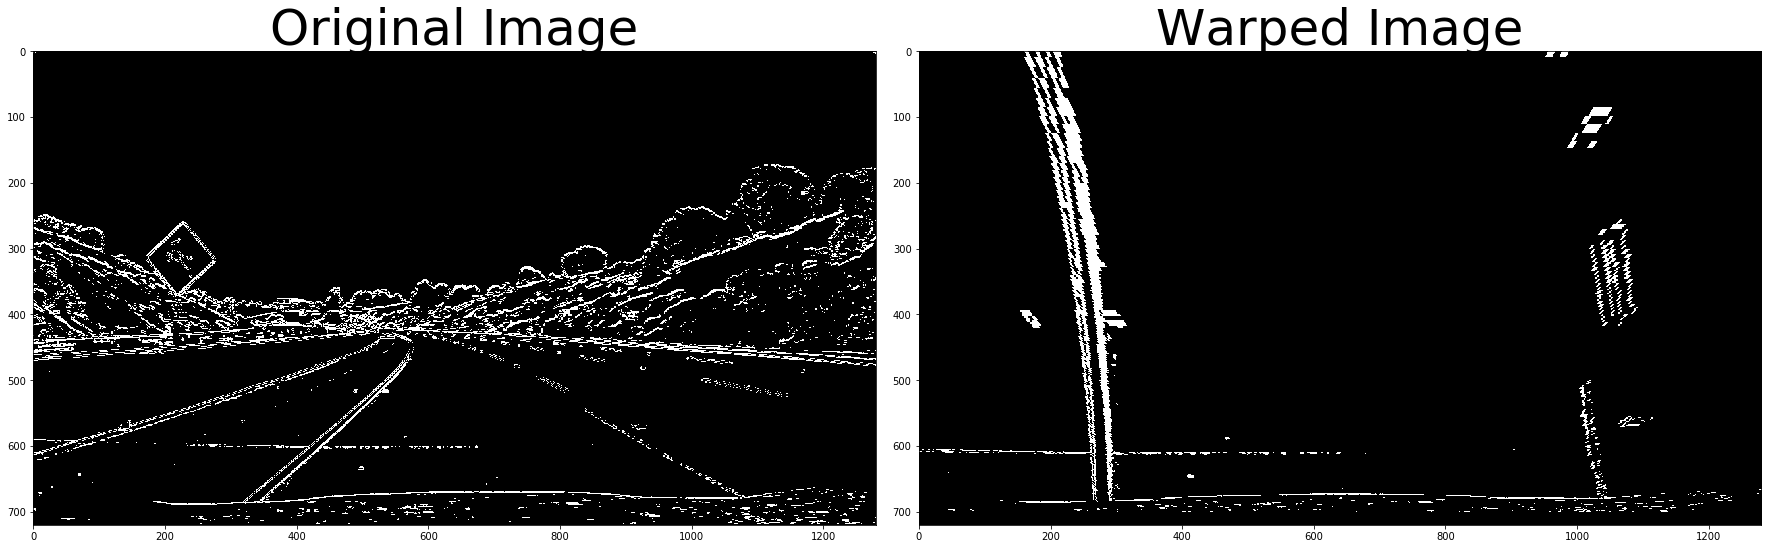

In [28]:
#Transform
def transform_image(img, nx, ny): 
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, M

def visualize_transorm_image(combined_binary, warped_img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
combined_binary = combined_transform(image)
warped_img, M = transform_image(combined_binary, nx, ny) 
visualize_transorm_image(combined_binary, warped_img)


# Final Steps for our project:

## 1. Calibrate the Camera
## 2. Distortion Correction
## 3. Color and Gradient Threshold
## 4. Perspective Transform

After this we would 
## 5 decide which pixels are lane line pixels,
## 6 Then we would determine the line shape and position.

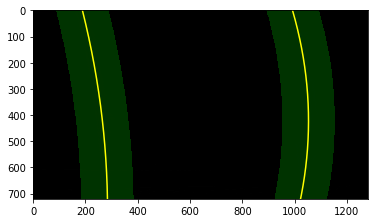

In [29]:
def locate_lines(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def locate_line_further(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new

def visualizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, binary_warped, nonzerox, nonzeroy, margin = 100):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
    
left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img) 
visualizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, warped_img, nonzerox, nonzeroy, margin = 100)
    

In [30]:
def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr
    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.752588921 m 648.157485143 m


In [31]:
# Finding the radius of curvature for lanes of our image
#Radius of Curvature
def radius_curvature(binary_warped, left_fit, right_fit):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center 

In [32]:
left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)

# Final Image that we would like to proceed with

In [33]:
def draw_on_image(undist, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values = False):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        
    return result

array([[[236, 240, 251],
        [207, 209, 217],
        [187, 182, 184],
        ..., 
        [ 46,  36,  26],
        [ 52,  43,  39],
        [ 54,  46,  46]],

       [[206, 199, 196],
        [163, 153, 146],
        [156, 142, 130],
        ..., 
        [ 87,  65,  47],
        [ 52,  33,  20],
        [ 59,  40,  32]],

       [[176, 155, 134],
        [180, 156, 132],
        [164, 136, 106],
        ..., 
        [156, 118,  86],
        [113,  78,  52],
        [ 69,  35,  12]],

       ..., 
       [[106, 113, 128],
        [ 71,  80,  94],
        [ 71,  80,  94],
        ..., 
        [ 64,  71,  88],
        [ 67,  74,  91],
        [108, 115, 132]],

       [[111, 119, 132],
        [ 80,  88, 101],
        [ 70,  79,  93],
        ..., 
        [ 69,  74,  89],
        [ 84,  89, 104],
        [115, 120, 135]],

       [[124, 132, 145],
        [105, 113, 126],
        [ 80,  89, 103],
        ..., 
        [ 53,  58,  73],
        [102, 107, 122],
        [127, 132,

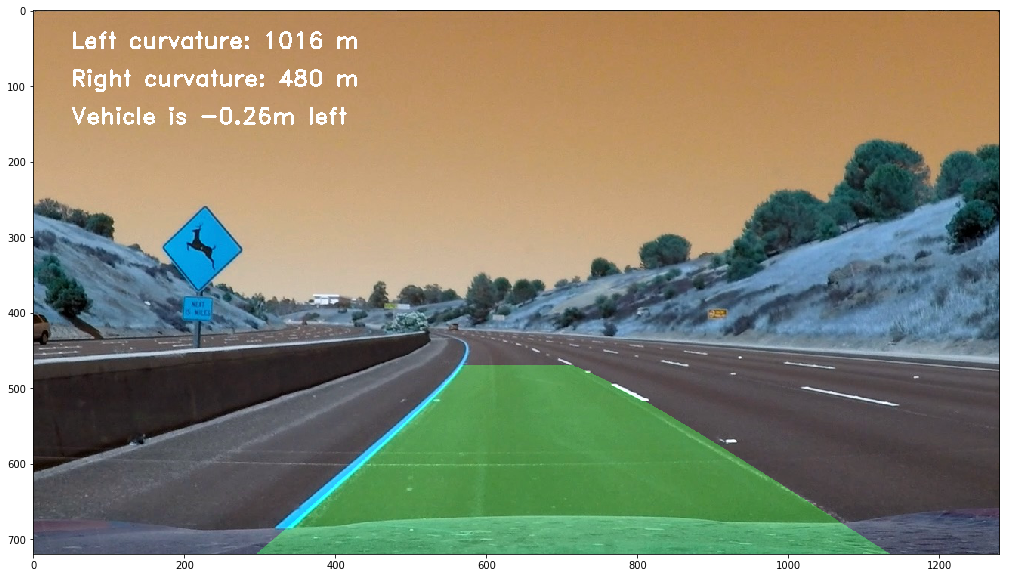

In [34]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, True)

# Few observations before we proceed with creating the pipeline.
1. I observed that there were few images on which lane lines couldn't be drawn.
> For such images, we need not proceed ahead with the video pipeline processing.
2. Once the image is entered to the pipeline, same image should be processed till the end, else the lines are drawn incorrectly.

Keeping the above points in my let's create our pipeline.


# Pipeline

1. First we'll find out the lane lines of the image. If it exist we move to next step, else we break off here.
2. Once lines are found out, we draw the lines and identify the lane.
3. Return the image with proper radius of curvature and other relevant information.

In [35]:
def pipeline(img):
    img = cv2.undistort(img, cameraMatrix, distortionCoeffs)
    combined_binary = combined_s_gradient_thresholds(img)
    warped_img, M = transform_image(combined_binary, nx, ny)
    left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img) 
    visualizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, warped_img, nonzerox, nonzeroy, margin = 100)
    left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)
    draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, True)
    return img
    

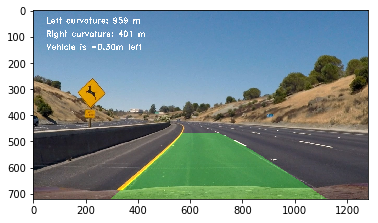

In [42]:
plt.imshow(pipeline(image))

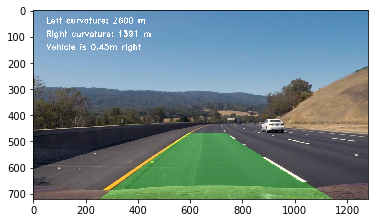

In [50]:
plt.imshow(pipeline(plt.imread('test_images/test3.jpg')))

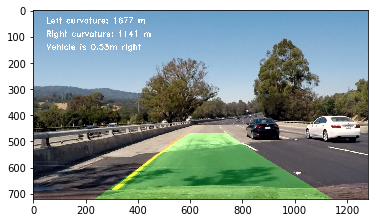

In [52]:
plt.imshow(pipeline(plt.imread('test_images/test4.jpg')))

In [53]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    return pipeline(img)

white_output = 'files/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video files/project_video_output.mp4
[MoviePy] Writing video files/project_video_output.mp4


100%|█████████▉| 1260/1261 [07:37<00:00,  2.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: files/project_video_output.mp4 

CPU times: user 5min 10s, sys: 12.4 s, total: 5min 22s
Wall time: 7min 41s


In [54]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))